$$ RETI\ NEURALI $$

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import librosa
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Bidirectional, LSTM, Activation, GRU, Conv2D, concatenate, MaxPooling2D, Flatten, Lambda, BatchNormalization, ReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import Adam
from keras.regularizers import l2

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import matplotlib.image as mpimg
from pylab import rcParams

plt.style.use("fivethirtyeight")

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.serif"] = "Ubuntu"
plt.rcParams["font.monospace"] = "Ubuntu Mono"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["image.cmap"] = "jet"
plt.rcParams["image.interpolation"] = "none"
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8

colors = [
    "xkcd:pale orange",
    "xkcd:sea blue",
    "xkcd:pale red",
    "xkcd:sage green",
    "xkcd:terra cotta",
    "xkcd:dull purple",
    "xkcd:teal",
    "xkcd:goldenrod",
    "xkcd:cadet blue",
    "xkcd:scarlet",
]
cmap_big = cm.get_cmap("Spectral", 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=0.5)

Carico i file **shuffled_train**, **shuffled_valid** e **test_arr** creati precedentemente:

In [5]:
npzfile = np.load("../data/shuffled_train.npz")
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']

npzfile = np.load("../data/shuffled_valid.npz")
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']

npzfile = np.load("../data/test_arr.npz")
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']

In [6]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)
print('Validation:', X_valid.shape, y_valid.shape)

Train: (6394, 640, 128) (6394, 8)
Test: (800, 640, 128) (800,)
Validation: (800, 640, 128) (800, 8)


Tramite la funzione **get_f1**, definisco la metrica *f1-Score* in modo da poterla usare nella rete neurale

In [7]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

La rete che abbiamo costruito lavora in parallelo usando una rete *Convolutional* e una rete *Recurrent*.

(-0.5, 1164.5, 182.5, -0.5)

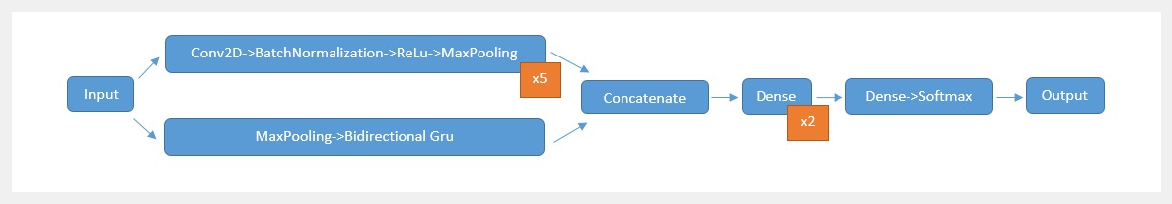

In [8]:
img = mpimg.imread("../pictures/Schema_Neural_Network.png")
rcParams['figure.figsize'] = 11, 2
plt.figure(dpi=120)  # Adjust the DPI to suit your display
imgplot = plt.imshow(img)
plt.axis("off")

**Rete Convolutional**

(-0.5, 321.5, 236.5, -0.5)

<Figure size 1320x240 with 0 Axes>

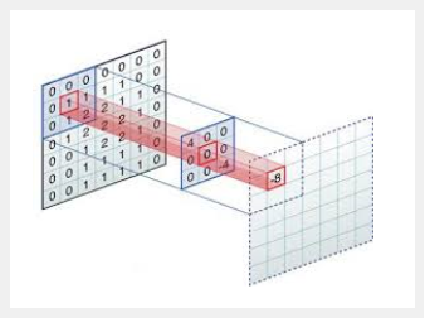

In [9]:
img = mpimg.imread("../pictures/Schema_CNN.png")
height, width, _ = img.shape
aspect_ratio = width / height
plt.figure(dpi=120)  # Adjust the DPI to suit your display
plt.figure(figsize=(5, 5 / aspect_ratio)) # set the figure size dynamically based on the image dimensions
imgplot = plt.imshow(img)
plt.axis("off")

Useremo le seguenti tecniche:

  -**Prodotto convolutivo**: Tramite la funzione Conv2D.

  -**Batch Normalization**: Tecnica usata per migliorare la velocità, le prestazioni e la stabilità delle reti neurali. Viene utilizzata per riscalare i dati di input lavorando su ogni mini-Batch .

  -**ReLu**: Funzione di attivazione non lineare applicata ad ogni elemento del volume. Si usa per evitare il problema del Vanishing Gradient (Il modulo del Gradiente, tende a diminuire man mano che ci si avvicina ai layer iniziali della rete).

  -**Max Pooling**: Tecnica di ridimensionamento dell'immagine che va a prendere il massimo da alcune sottoregioni dell'immagine. (Riduce la dimensionalità del volume in input con delle operazioni locali ottenendo un volume più piccolo ma con uguale profondità. Considera una regione di tale volume e restituisce il valore più grande. )
    

**Rete Recurrent**

(-0.5, 543.5, 247.5, -0.5)

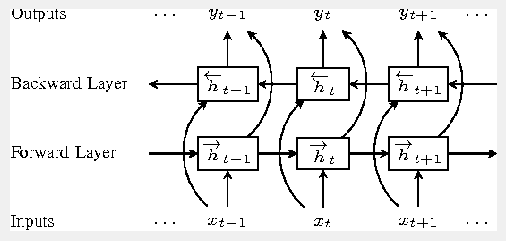

In [10]:
img = mpimg.imread("../pictures/Schema_RNN.png")
height, width, _ = img.shape
aspect_ratio = width / height
plt.figure(figsize=(6, 6 / aspect_ratio)) # set the figure size dynamically based on the image dimensions
imgplot = plt.imshow(img)
plt.axis("off")

La **Recurrent** è usata quando dobbiamo elaborare sequenze di dati. 

Tali reti hanno la caratteristica che l'output è in funzione del valore di input e di uno stato che contiene informazioni su tutti i dati precedenti. Quest'ultimo è aggiornato ad ogni istante di tempo.

In particolare useremo un tipo di rete Recurrent chiamata ***Bidirectional Gru***, ovvero aggiorniamo lo stato non solo con i dati precedenti ma anche con i successivi.

In [11]:
#Definisco delle costanti

num_classes = 8 #Numero delle classi

ksize = (3,1)   #Il kernel size è la dimensione del filtro.
                # Nel caso dello spettrogramma prenderemo per un istante di tempo frequenze adiacenti

pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

BATCH_SIZE = 64 #Numero di elementi considerati ad ogni iterazione dell'ottimizzatore
EPOCH_COUNT = 10 #Numero delle epoche
weight_decay = 0.01 #Parametro di regolarizzazione della Conv2D

In [12]:
#Questa funzione serve a costruire lo scheletro del modello

def conv_recurrent_model_build(model_input):
    print('Building model...')
    
    layer = model_input
    
    # Convolutional blocks

    conv_1 = Conv2D(filters = 16, kernel_size = ksize, strides=1, kernel_regularizer = l2(weight_decay), 
                    bias_regularizer = l2(weight_decay),
                      padding= 'valid', activation=None, name='conv_1')(layer)
    bnorm_1 = BatchNormalization(epsilon=1e-04)(conv_1)
    activ_1 = ReLU(negative_slope=0)(bnorm_1)    
    pool_1 = MaxPooling2D(pool_size_1)(activ_1)

    conv_2 = Conv2D(filters = 32, kernel_size = ksize, strides=1, kernel_regularizer = l2(weight_decay), 
                    bias_regularizer = l2(weight_decay),
                      padding= 'valid', activation=None, name='conv_2')(pool_1)    
    bnorm_2 = BatchNormalization(epsilon=1e-04)(conv_2)
    activ_2 = ReLU(negative_slope=0)(bnorm_2)    
    pool_2 = MaxPooling2D(pool_size_1)(activ_2)

    conv_3 = Conv2D(filters = 64, kernel_size = ksize, strides=1, kernel_regularizer = l2(weight_decay), 
                    bias_regularizer = l2(weight_decay),
                      padding= 'valid', activation=None, name='conv_3')(pool_2)
    bnorm_3 = BatchNormalization(epsilon=1e-04)(conv_3)
    activ_3 = ReLU(negative_slope=0)(bnorm_3)    
    pool_3 = MaxPooling2D(pool_size_1)(activ_3)    
    
    conv_4 = Conv2D(filters = 64, kernel_size = ksize, strides=1, kernel_regularizer = l2(weight_decay), 
                    bias_regularizer = l2(weight_decay),
                      padding= 'valid', activation=None, name='conv_4')(pool_3)
    
    bnorm_4 = BatchNormalization(epsilon=1e-04)(conv_4)
    activ_4 = ReLU(negative_slope=0)(bnorm_4)    
    pool_4 = MaxPooling2D(pool_size_2)(activ_4)    
    
    conv_5 = Conv2D(filters = 64, kernel_size = ksize, strides=1, kernel_regularizer = l2(weight_decay), 
                    bias_regularizer = l2(weight_decay),
                      padding= 'valid', activation=None, name='conv_5')(pool_4)    
    bnorm_5 = BatchNormalization(epsilon=1e-04)(conv_5)
    activ_5 = ReLU(negative_slope=0)(bnorm_5)    
    pool_5 = MaxPooling2D(pool_size_2)(activ_5)

    flatten1 = Flatten()(pool_5) #Metto tutti gli elementi su un vettore
    
    # Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer) #tipo di rete neurale ricorsiva
    
    # Embedding layer (modifiche sulla dimensione)
    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(64))(squeezed)  #default merge mode is concat #lstm_count=64
    
    #Concateno i 2 modelli, Convolutional e Recurrent
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat') 

    #Fully connected layer     
    fc_1 = Dense(512, activation = None, name='fc1')(concat)
    bnorm_6 = BatchNormalization(epsilon=1e-04)(fc_1)
    activ_6 = ReLU(negative_slope=0)(bnorm_6)

    fc_2 = Dense(1024, activation = None, name='fc2')(activ_6)
    bnorm_7 = BatchNormalization(epsilon=1e-04)(fc_2)
    activ_7 = ReLU(negative_slope=0)(bnorm_7)
    
    # Softmax (Nell'ultimo passo voglio avere 8 nodi perchè ho 8 classi da predire)
    output = Dense(num_classes, activation = 'softmax', name='preds')(activ_7)
       
    model_output = output
    
    model = Model(model_input, model_output)
                            
    return model

In [13]:
def train_model(x_train, y_train, x_val=None, y_val=None):

    # dimensioni dello spettrogramma
    n_frequency = 128
    n_frames = 640

    # Espandiamo la dimensione di x_train e x_val di 1 per poterli usare in Conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)

    # Dimensione dell'input ovvero la dimensione in entrata della rete
    input_shape = (n_frames, n_frequency, 1)

    model_input = Input(input_shape, name='input')

    # Clear memory after training session
    K.clear_session()

    model = conv_recurrent_model_build(model_input)

    # Ottimizzatore
    opt = Adam(lr=0.001, decay=0.05)
    model.compile(
        loss="categorical_crossentropy",  # loss tipicamente usata per la classificazione multiclasse
        optimizer=opt,  # L'ottimizzatore è il metodo con cui ottimizziamo la loss
        metrics=[get_f1],  # La metrica per noi è l'f1-score
    )

    print(
        model.summary()
    )  # stampo lo scheletro della rete neurale, i parametri che posso addestrare ecc..
    # stampo anche l'aggiornamento per ogni epoca

    # Salvo dei checkpoint per non riaddestrare la rete ogni volta
    # Gli dico dove salvare il check, quale valore monitorare e di salvare
    # i pesi rispetto al valore che sto monitorando

    checkpoint_callback = ModelCheckpoint('..\models\weights.best.h5', monitor='val_get_f1', verbose=1,
                                          save_best_only=True, mode='max')

    reducelr_callback = ReduceLROnPlateau(
                monitor='val_get_f1', factor=0.5, patience=5, min_delta=0.01, 
                verbose=1
            )

    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fitto il modello e tengo traccia delle operazioni fatte:
    print('Training...')

    if x_val is not None and y_val is not None:
        # Include validation data if provided
        history = model.fit(
            x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
            validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list
        )
    else:
        # Skip validation if no validation data is provided
        history = model.fit(
            x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
            verbose=1
        )


    return model, history

In [14]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 640, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 638, 128, 16  64          ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 638, 128, 16  64         ['conv_1[0][0]']                 
 alization)                     )                                           

In [15]:
# Salvo il modello dentro un file esterno
model_json = model.to_json()
with open("../models/model_training.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("../models/model_training.h5")
print("Saved model to disk")

# Salvo l'History dentro un file esterno
dictHistory = history.history
f = open("../models/dictHistory.txt", "w")
f.write( str(dictHistory) )
f.close()

Saved model to disk


In [16]:
# Carico il modello da un file esterno
json_file = open("../models/model_training.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("../models/model_training.h5")
print("Loaded model from disk")

# Carico l'History da un file esterno
r = open("../models/dictHistory.txt", "r").read()
dictHistory = eval(r)

Loaded model from disk


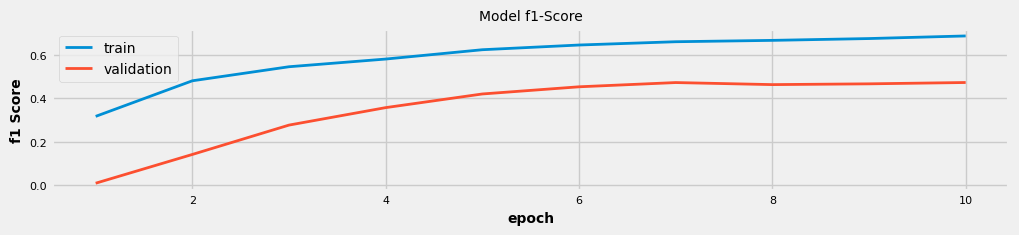

In [17]:
#Stampo l'f1 Score al variare delle epoche sia sul Training Set che sul Validation Set

xRow = list(range(1,EPOCH_COUNT+1))

plt.plot(xRow, dictHistory['get_f1']) #f1 sul training
plt.plot(xRow, dictHistory['val_get_f1']) #f1 sul validation

plt.title('Model f1-Score')
plt.ylabel('f1 Score')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')

plt.show()


Riaddestro il modello unendo il Training Set e il Validation Set

In [18]:
x = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))

In [19]:
del X_train, X_valid

In [20]:
model, history = train_model(x, y)

Building model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 640, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 638, 128, 16  64          ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 638, 128, 16  64         ['conv_1[0][0]']                 
 alization)                     )                                           

In [21]:
# Salvo il modello dentro un file esterno
model_json = model.to_json()
with open("../models/model_final.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("../models/model_final.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
# Carico il modello da un file esterno
json_file = open("../models/model_final.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("../models/model_final.h5")
print("Loaded model from disk")

Loaded model from disk


In [23]:
#Verifico il valore dell'f1 score sul Test Set
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }
y_test -= 1
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
X_test = np.log(X_test_raw)
y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

25/25 [==============================] - 2s 36ms/step
               precision    recall  f1-score   support

   Electronic       0.53      0.43      0.48       100
 Experimental       0.41      0.39      0.40       100
         Folk       0.55      0.52      0.53       100
      Hip-Hop       0.69      0.66      0.68       100
 Instrumental       0.46      0.48      0.47       100
International       0.53      0.63      0.58       100
          Pop       0.25      0.24      0.24       100
         Rock       0.56      0.63      0.59       100

     accuracy                           0.50       800
    macro avg       0.50      0.50      0.50       800
 weighted avg       0.50      0.50      0.50       800



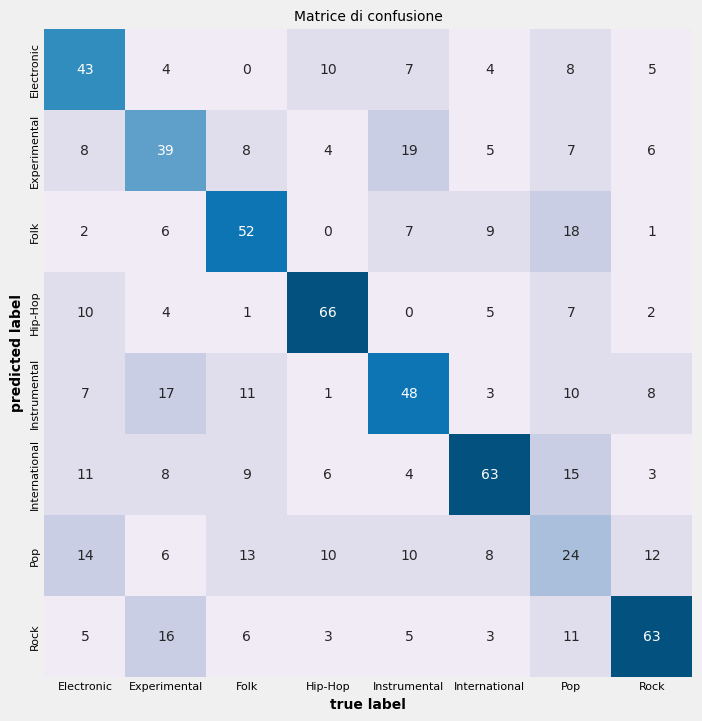

In [25]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred, target_names=target_names))

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
             cmap=sns.color_palette("PuBu", 10),
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.title('Matrice di confusione')
plt.xlabel('true label')
plt.ylabel('predicted label');